In [ ]:
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import matplotlib.pyplot as plt

In [ ]:
def evaluate_corruption(model, corruption_file, severity, batch_size=256):

    try:
        data = np.load(corruption_file)
    except ValueError as e:
        print(f"Error loading {corruption_file}: {e}")
        print("This typically means the .npy file is corrupted or malformed, or its internal shape metadata does not match the actual data size.")
        print("Please check the integrity and format of your .npy corruption files.")
        raise

    try:
        labels = np.load("labels.npy")
    except ValueError as e:
        print(f"Error loading labels.npy: {e}")
        print("This typically means the labels.npy file is corrupted or malformed.")
        raise

    start = (severity - 1) * 10000
    end = severity * 10000


    if len(data) < end:
        raise IndexError(f"Corruption file '{corruption_file}' does not contain enough data for severity {severity}. Expected at least {end} items, but found only {len(data)}.")
    if len(labels) < end:
        raise IndexError(f"Labels file 'labels.npy' does not contain enough data for severity {severity}. Expected at least {end} labels, but found only {len(labels)}.")

    images = torch.tensor(data[start:end]).permute(0,3,1,2).float() / 255.0
    labels = torch.tensor(labels[start:end])

    dataset = TensorDataset(images, labels)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    correct = 0
    total = 0

    model.eval()

    with torch.no_grad():
        for imgs, labs in loader:
            imgs = imgs.to(device)
            labs = labs.to(device)

            outputs = model(imgs)
            preds = outputs.argmax(1)

            correct += preds.eq(labs).sum().item()
            total += labs.size(0)

    return 100 * correct / total

In [ ]:
class SimpleModel(nn.Module):
    def __init__(self):
        super(SimpleModel, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(3 * 32 * 32, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleModel().to(device)

corruptions = {
    "Contrast": "contrast.npy",
    "Fog": "fog.npy",
    "Motion Blur": "motion_blur.npy"
}

severities = [1,2,3,4,5]

results = {}

for name, file in corruptions.items():

    acc_list = []

    print(f"\n{name}")

    for sev in severities:
        acc = evaluate_corruption(model, file, sev)
        acc_list.append(acc)

        print(f"Severity {sev}: {acc:.2f}%")

    results[name] = acc_list


Contrast
Severity 1: 9.62%
Severity 2: 9.60%
Severity 3: 9.72%
Severity 4: 9.73%
Severity 5: 9.76%

Fog
Severity 1: 9.42%
Severity 2: 9.56%
Severity 3: 9.55%
Severity 4: 9.65%
Severity 5: 9.80%

Motion Blur
Severity 1: 9.58%
Severity 2: 9.54%
Severity 3: 9.65%
Severity 4: 9.67%
Severity 5: 9.58%


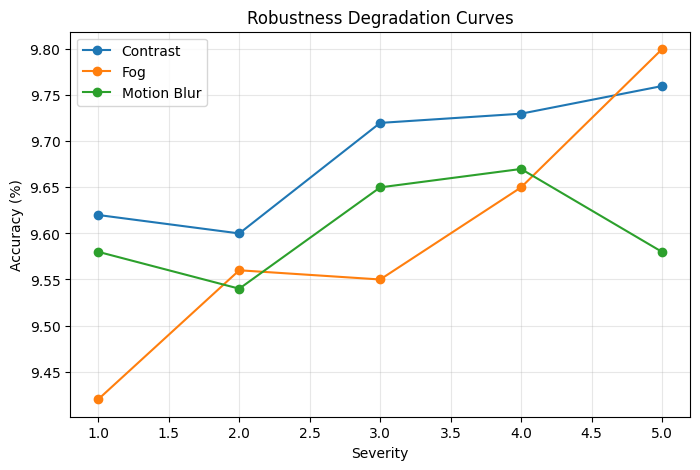

In [ ]:
plt.figure(figsize=(8,5))

for corruption, accs in results.items():
    plt.plot(severities, accs, marker='o', label=corruption)

plt.xlabel("Severity")
plt.ylabel("Accuracy (%)")

plt.title("Robustness Degradation Curves")

plt.legend()
plt.grid(alpha=0.3)

plt.savefig("severity_curves.png", dpi=400, bbox_inches='tight')

plt.show()